# IBM Analog Hardware Acceleration Kit (AIHWKIT): from device characteristic to DNN Training

### Authors: [Fabio Carta](https://www.linkedin.com/in/fabiocarta83/), [Malte Rasch](https://www.linkedin.com/in/malte-j-rasch-08731817/), and [Kaoutar El Maghraoui](https://www.linkedin.com/in/kaoutar-el-maghraoui/)

In this notebook, we first introduce general key concepts. Second, we imagine a scenario where we start from the electrical characteristic of the in-memory device we want to use. We use the fitting utility to create a model of the characterized device and then define an rpu_config, an abstraction used to represent many hardware details of a possible in-memory computing tile that leverages the characterized device. We then use the in-memory computing tile to train a simple network with different training algorithms.

<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/tutorial/analog_training.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

The IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open-source Python toolkit for exploring and using the capabilities of in-memory computing devices (PCM, RRAM and others) in the context of artificial intelligence.
The PyTorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch.

The GitHub repository can be found at: https://github.com/IBM/aihwkit

To learn more about Analog AI and the harware befind it, refer to this webpage: https://aihw-composer.draco.res.ibm.com/about


### Installing the AIHWKIT
The first thing to do is install the AIHWKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [ ]:
# To install the cpu-only enabled kit, un-comment the line below
# %pip install aihwkit

# To install the GPU-enabled wheel go to https://aihwkit.readthedocs.io/en/latest/advanced_install.html#install-the-aihwkit-using-pip
# and copy the option on GPU options that best suits your enviroment and paste it below and run the cell. For example, Python 3.10 and CUDA 12.1:
# !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# %pip install aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [1]:
# Install some prerequisites
%pip install pandas lmfit pytorch-lightning

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached aiohttp-3.11.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached frozenlist-1.5.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached propcache-0.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached yarl-1.18.3-cp310-cp310-manylinu

If the library was installed correctly, you can use the following snippet for creating an analog layer and predicting the output. In the code snippet below AnalogLinear is the Analog equivalent to Linear PyTorch layer.

In [2]:
from torch import Tensor
from aihwkit.nn import AnalogLinear

model = AnalogLinear(2, 2)
model(Tensor([[0.1, 0.2], [0.3, 0.4]]))

tensor([[ 0.2938, -0.1078],
        [ 0.2185, -0.3525]], grad_fn=<AddBackward0>)

## RPU Configuration

AIHWKIT offers different Analog layers that can be used to build a analog networks, including AnalogLinear, AnalogConv2d, AnalogRNN.
These various layers, in addition to the standard input that are expected by the PyTorch counterpart (such as in_channels, out_channels, etc.), also expect an `rpu_config` input.
The `rpu_config` is used to define many of the hardware specs of the in-memory compute tile and the device that it uses. Examples of these properties are: the number of bits used by the Analot to Digital (ADC) and Digital to Analog converters, device behavior (IdealDevice, ConstantStepDevice, SoftBoundsDevice, etc.), device properties (number of devices in each cell, minimum conductance step size, device to device variability of minimum conductance step size, etc.), tile size (number of cells columns by rows making the memory tile), weight noise type (none, additive constant, etc.) and many other properties.
Additional details on the RPU configuration can be found at https://aihwkit.readthedocs.io/en/latest/using_simulator.html#rpu-configurations

Here is a simple example that defines a hardware tile that supports in-memory SGD (with stochastic pulses).

In [3]:
from aihwkit.simulator.configs import SoftBoundsReferenceDevice, SingleRPUConfig

rpu_config = SingleRPUConfig(device=SoftBoundsReferenceDevice())
print(rpu_config)


SingleRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(),
    update=UpdateParameters(),
    device=SoftBoundsReferenceDevice()
)


All aspects of the hardware can be configured. For instance, if one wants to set the tile size to 256, the backward pass to ideal and increase the output noise of the forward pass, one could simply do

In [4]:
rpu_config.mapping.max_input_size = 256
rpu_config.mapping.max_output_size = 256
rpu_config.backward.is_perfect = True
rpu_config.forward.out_noise = 0.1

print(rpu_config)

SingleRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(max_input_size=256, max_output_size=256),
    forward=IOParameters(out_noise=0.1),
    backward=IOParameters(is_perfect=True),
    update=UpdateParameters(),
    device=SoftBoundsReferenceDevice()
)


These rpu_config parameters could be used to define single analog layers (see below) or could be used to conveniently convert all applicable layers of a given digital model using the available conversion utility. See the example below:

In [5]:
from torchvision.models import resnet18
from aihwkit.nn.conversion import convert_to_analog_mapped

analog_model = convert_to_analog_mapped(resnet18(), rpu_config=rpu_config)

print(analog_model)

AnalogWrapperResNet(
  (conv1): AnalogConv2dMapped(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False, SingleRPUConfig
    (array): ModuleList(
      (0): ModuleList(
        (0): AnalogTile(RPUPulsed<float>[SoftBoundsReference](64,147))
      )
    )
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): AnalogSequential(
    (0): BasicBlock(
      (conv1): AnalogConv2dMapped(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, SingleRPUConfig
        (array): ModuleList(
          (0): ModuleList(
            (0): AnalogTile(RPUPulsed<float>[SoftBoundsReference](64,198))
          )
          (1-2): 2 x ModuleList(
            (0): AnalogTile(RPUPulsed<float>[SoftBoundsReference](64,189))
          )
        )
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

Note that all convolutions and linear modules have been replaced by their analog counterparts. We use the "mapped" layers to convert large weight matrices to a logical array of physical tiles. To show some information about the converted DNN,  your can use `analog_info` utility.


In [6]:
from aihwkit.utils.analog_info import analog_summary

analog_summary(analog_model,(1, 3, 224, 224), rpu_config)

Model Name: AnalogWrapperResNet
Per-layer Information
Layer Information                                                     | Tile Information              
Layer Name          Is Analog           In Shape            Out Shape           Kernel Shape        # of Tiles          Reuse Factor        Log. tile shape     Phys. tile shape    utilization (%)     
AnalogConv2dMapped  analog              [1, 3, 224, 224]    [1, 64, 112, 112]   (7, 7)              1                   12544               -                   -                   -                   
                                                                                                                                            (64, 147)           (256, 256)          14.36               
BatchNorm2d         digital             [1, 64, 112, 112]   [1, 64, 112, 112]   -                   0                   0                   -                   -                   -                   
ReLU                digital            

## Device characterization and parameter fitting
In this notebook scenario, we start from the electrical characterization of novel Resistive Random Access Memory (RRAM) devices. A typical way of testing the RRAM device targeted for in memory computing application is to provide a series of equal pulses (usually 200) designed to increment the device conductance to its maximum level (G_max) and then a series of equal pulses designed to change the conductance to its minimum value (G_min). The next step is to apply a series of pulses consisting of one pulse aimed at incrementing the conductance followed by a pulse aimed at decrementing the conductance. This last train of pulses has the effect of placing the device in what's called the Symmetry Point (SP) which is the point where the change in conductance (dw^+) caused by an incrementing pulse is equal to the change in conductance (dw^{-}) caused by a decrementing pulse. More details can be found in [Gong et al., IEDM 2022](https://ieeexplore.ieee.org/document/10019569).

We can extract all the needed parameters by using the fitting utility and then use the parameters to customize a general device mode. In the code below we define a general device behavior based on the SoftBoundsDevice model, which best represent the electrical response of the RRAM device under study. Without any noise the pulse response curve (i.e. giving a series of positive pulses and negative pulses) can be visualized as follows:   

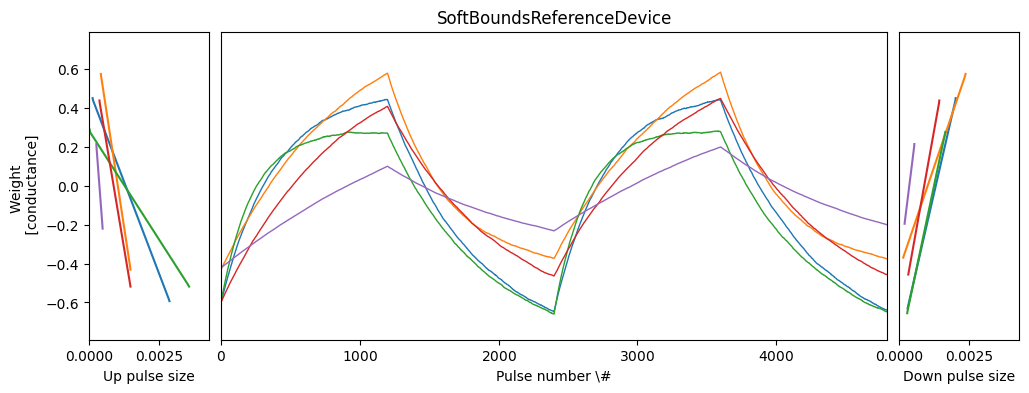

In [7]:
from aihwkit.utils.visualization import plot_device_compact
from aihwkit.simulator.configs import SoftBoundsReferenceDevice

device_config = SoftBoundsReferenceDevice()
plot_device_compact(device_config, n_traces=5);

This shows on the side plots, that the pulse size is linearly dependent on the current conductance, thus implementing a soft saturation of the conductance (see API reference for `SoftBoundsReferenceDevice` for details). Above, 5 traces are plotted with standard device-to-device variation. This can be adjusted. For instance, below all the device-to-device parameters are set to zero, but retaining some pulse-to-pulse variations (`dw_min_std`).   

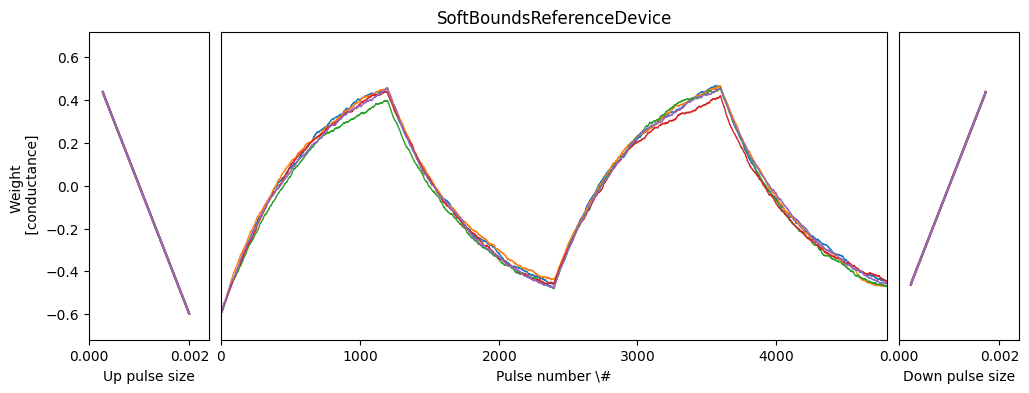

In [8]:
device_config_plain = SoftBoundsReferenceDevice(w_min_dtod=0.0, w_max_dtod=0.0, dw_min_dtod=0.0, up_down_dtod=0.0, dw_min_std=1.0)
plot_device_compact(device_config_plain, n_traces=5);

We can now load the RRAM electrical response data, as characterize in [Gong et al., IEDM 2022](https://ieeexplore.ieee.org/document/10019569)  and visualize the real device up and down response.

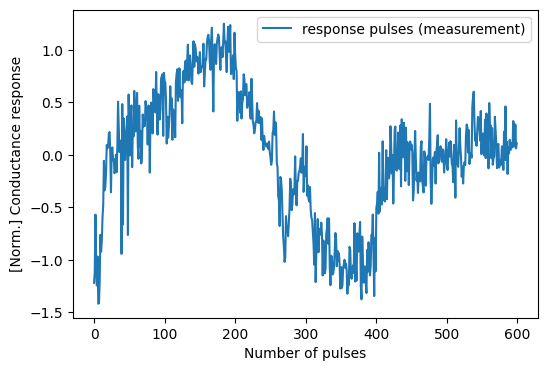

In [9]:
from numpy import ones, absolute, concatenate, tile, average
import matplotlib.pyplot as plt
import requests
from pandas import read_csv

url = 'https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/IEDM_2022.csv'
response = requests.get(url)
with open('IEDM_2022.csv', 'wb') as file:
	file.write(response.content)

df = read_csv('IEDM_2022.csv', header=None)
response = df[0].values
response -= response.mean()
response /= absolute(average(response[180:200]))

figure = plt.figure(figsize=[6, 4])
plt.plot(response, label='response pulses (measurement)')
plt.xlabel("Number of pulses")
plt.ylabel("[Norm.] Conductance response")
plt.legend()
plt.gcf()
plt.show()

We use the provided fitting utility to fit the parameters `dw_min` (pulse width at weight zero), `w_max` and `w_min` (min and maximim bound in normalized units), and `up_down` which is the amount of asymmetry between up and down behaviour. The fitting tool expects the initial setting and ranges of these parameters

In [10]:
params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

Now we can use the "powell" method to fit to the device measurements.

In [11]:
from aihwkit.utils.fitting import fit_measurements
up_down = [1, -1]
up_down = tile(up_down, 100)
pulses = concatenate([ones(200), -ones(200), up_down])

result, device_config_fit, best_model_fit = fit_measurements(
    params,
    pulses,
    response,
    device_config)

print(device_config_fit)

SoftBoundsReferenceDevice(
    dw_min=0.020470346964324024,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.33704489385280056,
    up_down_dtod=0.0,
    w_max=0.8486431288966343,
    w_max_dtod=0.0,
    w_min=-1.02220239921561,
    w_min_dtod=0.0
)


We can then overlap the fitted model to the measured electrica data to check how good is the obtained fit.

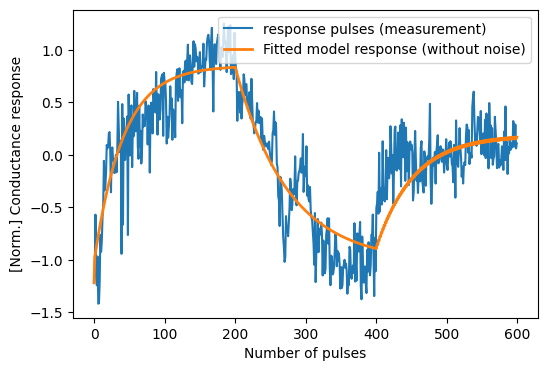

In [12]:
figure = plt.figure(figsize=[6, 4])
plt.plot(response, label='response pulses (measurement)')
plt.xlabel("Number of pulses")
plt.ylabel("[Norm.] Conductance response")

plt.plot(best_model_fit, linewidth=2, label='Fitted model response (without noise)')
plt.legend()
plt.gcf()
plt.show()

Since, in this example, we only have one device measurement; we have to guess the device-to-device variation. Additionally, the above code does not estimate the noise. However, we can simply do that using the code below:

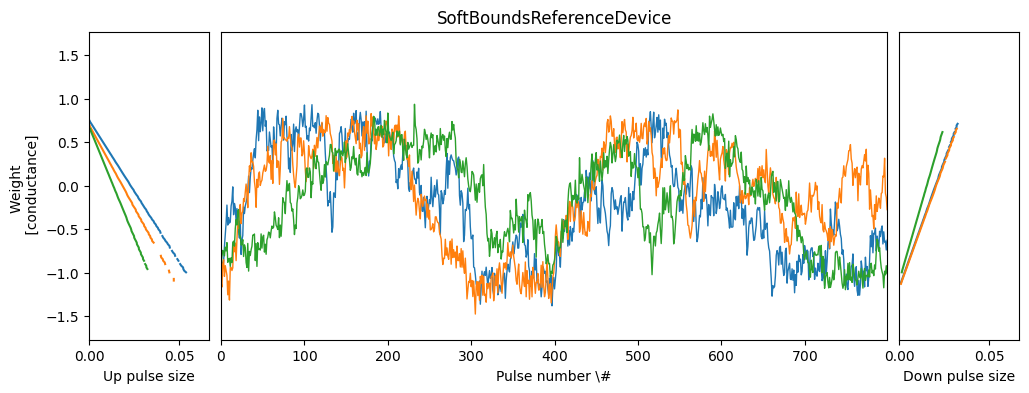

In [13]:
from numpy import sqrt

# add some device-to-device varition and noise
std = (response[500:] - best_model_fit[500:]).std() / device_config_fit.dw_min
device_config_fit.dw_min_dtod = 0.3
device_config_fit.dw_min_std = 5.0
device_config_fit.w_min_dtod = 0.1
device_config_fit.w_max_dtod = 0.1
device_config_fit.up_down_dtod = 0.05
device_config_fit.write_noise_std = sqrt(std ** 2 - device_config_fit.dw_min_std ** 2)/2
device_config_fit.subtract_symmetry_point = True
device_config_fit.reference_std = 0.05  # assumed programming error of the reference device
device_config_fit.enforce_consistency=True  # do not allow dead devices
device_config_fit.dw_min_dtod_log_normal=True # more realistic to use log-normal
device_config_fit.mult_noise=False # additive noise
device_config_fit.construction_seed = 123

plot_device_compact(device_config_fit, n_traces=3, n_steps=200);

## In-memory training with custom device configuration

Now that we have defined our custom device, we can move forward with the `rpu_config` definition which will customize the remaining part of the analog tile. The `rpu_config` definition customizes the remaining part of the analog tile.

We first need to define which kind of optimizer we will be using for training the network. The analog device response curve is usually non-linear and non-symmetric and performs poorly with the Stochastic Gradient Descent (SGD) algorithm. However, SGD has a relative simple rpu_config, and it is also a good baseline to compare against the performance of specialized analog training optimizer (such as the Tiki-Taka algorithm), which we will review later in this notebook.

Starting with SGD, we can define a function that will return the rpu_config suitable for SGD. In the code below, we define a sgd_rpu_config where we use the custom `SoftBoundReference` device we fitted to the data.

Other parameters such as defining the MVM non-linearities of the forward and backward passes, the mapping to tiles, and the digital periphery can be customized by setting the corresponding fields in the `rpu_config`. We leave them at default values here.

As an example of how one would customize the configuration, we set a non-standard pulse behavior of the update. The UpdateParameters can be used to customize how we set a non-standard pulse behavior of the update. The UpdateParameters can be used to customize how the analog tile delivers the updated pulses to the device to change the conductance states. In this in-memory training example, the crossbar array uses two stochastic bit streams of pulses applied to the row and columns of the device, needing an update, to change its conductance. When the pulses coincide, an update will happen as further explained in [Gokmen & Vlasov, Front. Neurosci. 2016](https://www.frontiersin.org/articles/10.3389/fnins.2016.00333/full). The (maximal) length of the stochastic bit stream is defined through the desired_bl parameter which is set to 10.



In [14]:
from aihwkit.simulator.configs import SingleRPUConfig, UpdateParameters

def get_sgd_rpu_config():
    rpu_config = SingleRPUConfig(device=device_config_fit, update=UpdateParameters(desired_bl=10))
    return rpu_config

We can now start creating the network and using the `rpu_config` above to train it.
We use a model previously used in literature for analog-ai application benchmarking. The model is composed of 3 fully connected layers with 784, 256, 128, and 10 neurons. This network is trained on the standard MNIST dataset comprising 60,000 training images. We used the sigmoid and softmax activation functions for the hidden and output layer w. The network will be trained for 100 epochs with a learning rate of 0.05 which will be decayed at the 50th and 80th epoch.

We can use the standard PyTorch library to code the network structure. We will later use a handy AIHWKIT method to automatically take the defined network and convert it to its analog equivalent.

In [15]:
from torch import nn

def create_network():
    """Create the neural network using digital layers.
    Returns:
        nn.Module: created analog model
    """

    input_size = 784
    hidden_sizes = [256, 128]
    output_size = 10

    model = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[1], output_size, True),
        nn.LogSoftmax(dim=1)
    )
    return model

To reduce space and effort,  we here define the training using PyTorch lightning (see the [examples](https://github.com/IBM/aihwkit/tree/master/examples) in the AIHWKIT for a more explicit definition of the training)   

In [16]:
from torch import argmax
from torch.nn.functional import nll_loss
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

from aihwkit.optim import AnalogSGD
from aihwkit.nn.conversion import convert_to_analog_mapped


class LitAnalogModel(pl.LightningModule):
    def __init__(self, model, rpu_config, lr=0.05):
        super().__init__()

        # We simply convert the given model to analog on-the-fly
        self.analog_model = convert_to_analog_mapped(model, rpu_config)
        self.lr = lr

    def forward(self, x):
        x_reshaped = x.reshape(x.shape[0], -1)
        return self.analog_model(x_reshaped)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nll_loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        # we need to use the analog-aware optimizers
        optimizer = AnalogSGD(
            self.analog_model.parameters(),
            lr=self.lr,
        )
        return optimizer


We use the standard PyTorch library to define and download the training and test MNIST datasets and import some necessary libraries.

In [17]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


PATH_DATASET = os.path.join('data', 'DATASET')
os.makedirs(PATH_DATASET, exist_ok=True)

def get_data_loaders(batch_size=5):
    """Get the data loaders for train from torchvision datasets."""

    train_set = MNIST(PATH_DATASET, download=True, train=True, transform=ToTensor())
    test_set = MNIST(PATH_DATASET, download=True, train=False, transform=ToTensor())
    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    test_data = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_data, test_data


Now we start the training using PyTorch lightning. Note that in the code below, the number of training epochs is set to 3 to limit the training time, but it can be increased to many more epochs if time/resources allow.

In [18]:
from pandas import read_csv

# reduce the output verbosity
import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.CRITICAL)


def build_trainer(rpu_config, lr=0.1, max_epochs=3, log="1"):
    """Build the lightning model and resurn the trainer"""

    trainer = pl.Trainer(
        enable_model_summary=False,
        logger=pl.loggers.CSVLogger(save_dir=os.path.join("logs", log)),
        callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=10)],
        max_epochs=max_epochs,
    )

    model = LitAnalogModel(lr=lr, rpu_config=rpu_config, model=create_network())
    return trainer, model

def fit_model(trainer, model):
    """Train the model using lightning trainer."""

    trainer.fit(model, *get_data_loaders(batch_size=5))
    trainer.test(model, get_data_loaders(batch_size=100)[1])

def plot_loss(trainer, tstr=''):
    """Plot the train loss for each batch."""
    metrics = read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    metrics.plot("step", "train_loss")
    plt.ylabel("Loss")
    plt.title(tstr)
    return plt.gcf()


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 7905149.57it/s] 


Extracting data/DATASET/MNIST/raw/train-images-idx3-ubyte.gz to data/DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 293264.87it/s]


Extracting data/DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to data/DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2780191.91it/s]


Extracting data/DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to data/DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2242821.85it/s]


Extracting data/DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/DATASET/MNIST/raw

Testing DataLoader 0: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4749999940395355
        test_loss           1.4772865772247314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


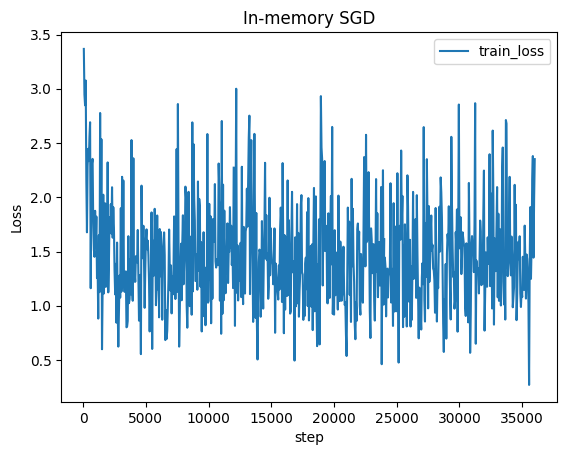

In [19]:
trainer, model = build_trainer(get_sgd_rpu_config(), log="sgd")
fit_model(trainer, model)
plot_loss(trainer, "In-memory SGD");

### Training with specialized in-memory SGD algorithms

The accuracy that is achieved by the network using in-memory computing with SGD is low. This is due to the non-idealities of the device used in the cross-point array, which are not accounted for in the standard SGD algorithm. This demonstrates that innovations at the algorithmic level are needed to enable accurate analog in-memory computing.

IBM Research is developing new training algorithms which can alleviate the non-idealities of these devices achieving high network accuracy. In this notebook, we explore the Tiki-Taka algorithm which eliminates the stringent symmetry requirement to increase and decrease of device conductance.
SGD and Tiki-Taka both use the error backpropagation. Still, they process the gradient information differently and are fundamentally different algorithms. Tiki-Taka replaces each weight matrix W of SGD with two matrices, referred to as matrix A and C. Then, it creates a coupled dynamical system by exchanging information between the two. We showed that in the Tiki-Taka dynamics, the non-symmetric behavior is a valuable and needed property of the device; therefore, it is ideal for many non-symmetric device technologies.

More details on the Tiki-Taka can be found at:

https://www.frontiersin.org/articles/10.3389/fnins.2020.00103/full

https://www.frontiersin.org/articles/10.3389/frai.2021.699148/full

The Tiki-Taka algorithm can be implemented by adjusting the RPU configuration of the network. In this case, we use two devices per cross-point and define additional parameters specific to the Tiki-Taka algorithm.



#### Training with Tiki-Taka version 2
We  can use the `build_config` utility to build an `rpu_config` for different specialized in-memeory training algorithms such as Tiki-Taka. Here, we choose the more advanced Tiki-taka version 2 algorithm (TTv2) which adds an additional digital buffer to the orginal Tiki-taka algorithm. See https://arxiv.org/abs/2303.04721 for details.  

In [20]:
from aihwkit.simulator.configs import build_config

algorithm = 'ttv2'  # one of tiki-taka, ttv2, c-ttv2, mp, sgd, agad

rpu_config = build_config(algorithm, device=device_config_fit, construction_seed=123)
# update onto A matrix needs to be increased somewhat
rpu_config.mapping.learn_out_scaling = True
rpu_config.mapping.weight_scaling_columnwise = True
rpu_config.mapping.weight_scaling_omega = 0.6
rpu_config.device.fast_lr = 0.01
rpu_config.device.auto_granularity=15000

print(rpu_config)

UnitCellRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(weight_scaling_omega=0.6, weight_scaling_columnwise=True, learn_out_scaling=True),
    forward=IOParameters(),
    backward=IOParameters(),
    update=UpdateParameters(desired_bl=5),
    device=ChoppedTransferCompound(
        unit_cell_devices=[
            SoftBoundsReferenceDevice(
                construction_seed=123,
                dw_min=0.020470346964324024,
                dw_min_dtod_log_normal=True,
                dw_min_std=5.0,
                reset_std=0.0,
                up_down=0.33704489385280056,
                up_down_dtod=0.05,
                w_max=0.8486431288966343,
                w_max_dtod=0.1,
                w_min=-1.02220239921561,
                w_min_dtod=0.1,
                write_noise_std=4.0254904007736805,
                reference_std=0.05,
                subtract_symmetry_point

Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 130.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7843999862670898
        test_loss           0.6429179310798645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


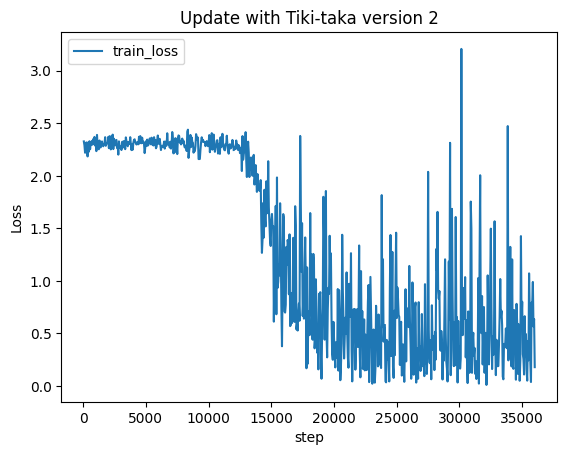

In [21]:
trainer, model = build_trainer(rpu_config, log="ttv2")
fit_model(trainer, model)
plot_loss(trainer, "Update with Tiki-taka version 2");

#### Training with Mixed-Precision
Similarly to what is done above, we can redefine the RPU configuration to use mixed precision for training. The mixed precision optimizer uses two matrices, similar to the Tiki-Taka algorithm. Still, in this case, one is computed in digital floating-point precision and then used to update the weight of the analog matrix.

In [22]:
algorithm = 'mp'  # or tiki-taka, ttv2, c-ttv2, mp, sgd

rpu_config = build_config(algorithm, device=device_config_fit, construction_seed=123)
print(rpu_config)

DigitalRankUpdateRPUConfig(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=IOParameters(),
    backward=IOParameters(),
    update=UpdateParameters(),
    device=MixedPrecisionCompound(
        device=SoftBoundsReferenceDevice(
            construction_seed=123,
            dw_min=0.020470346964324024,
            dw_min_dtod_log_normal=True,
            dw_min_std=5.0,
            reset_std=0.0,
            up_down=0.33704489385280056,
            up_down_dtod=0.05,
            w_max=0.8486431288966343,
            w_max_dtod=0.1,
            w_min=-1.02220239921561,
            w_min_dtod=0.1,
            write_noise_std=4.0254904007736805,
            reference_std=0.05,
            subtract_symmetry_point=True
        )
    )
)


As defined above, the same network can be reused with different RPU configurations.

Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 133.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9298999905586243
        test_loss           0.23679746687412262
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


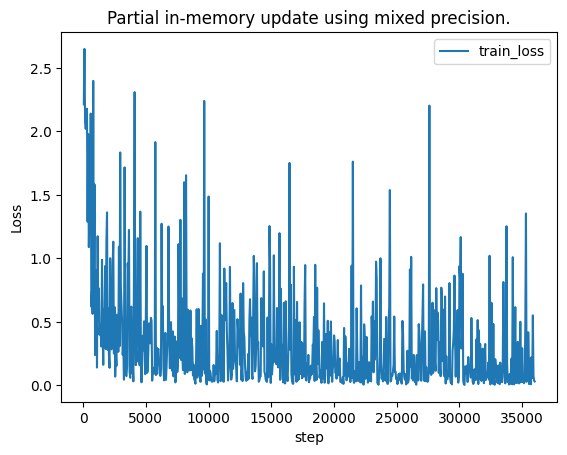

In [23]:
trainer, model = build_trainer(rpu_config, log="mp")
fit_model(trainer, model)
plot_loss(trainer, "Partial in-memory update using mixed precision.");